In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/fem_box/', 60) # x z

Loading ../data/BIOQIC/fem_box/60/wave.nc
Loading ../data/BIOQIC/fem_box/60/mre.nc
Loading ../data/BIOQIC/fem_box/60/mre_mask.nc


<IPython.core.display.Javascript object>


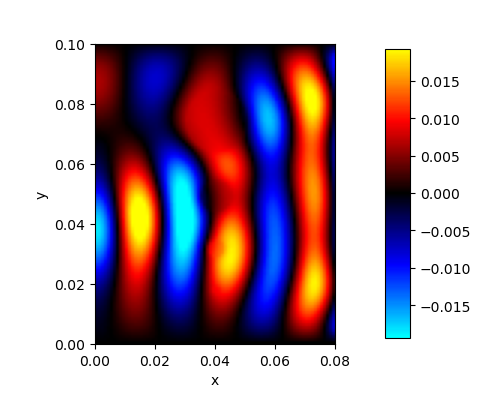

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [55]:
%autoreload
example.view('wave', ax_height=3)
#example.view('mre', ax_height=3, polar=True, vmax=1e4)

In [5]:
def print_arrays(**kwargs):
    for k, v in kwargs.items():
        print(f'{k} ∈ {v.dtype} {v.shape}')

In [145]:
wave = example.wave.sel(z=0, component=['x', 'z'])
mre = example.mre.sel(z=0)

x = wave.field.points()
u = wave.field.values()
mu = mre.field.values()

print_arrays(x=x, u=u, mu=mu)

x ∈ float64 (8000, 2)
u ∈ complex128 (8000, 2)
mu ∈ complex128 (8000, 1)


In [45]:
np.fft.fftfreq(10)

array([ 0. ,  0.1,  0.2,  0.3,  0.4, -0.5, -0.4, -0.3, -0.2, -0.1])

phi_x ∈ complex128 (8000, 6400)
Hphi_x ∈ complex128 (8000, 6400, 2, 2)
Lphi_x ∈ complex128 (8000, 6400)


<IPython.core.display.Javascript object>


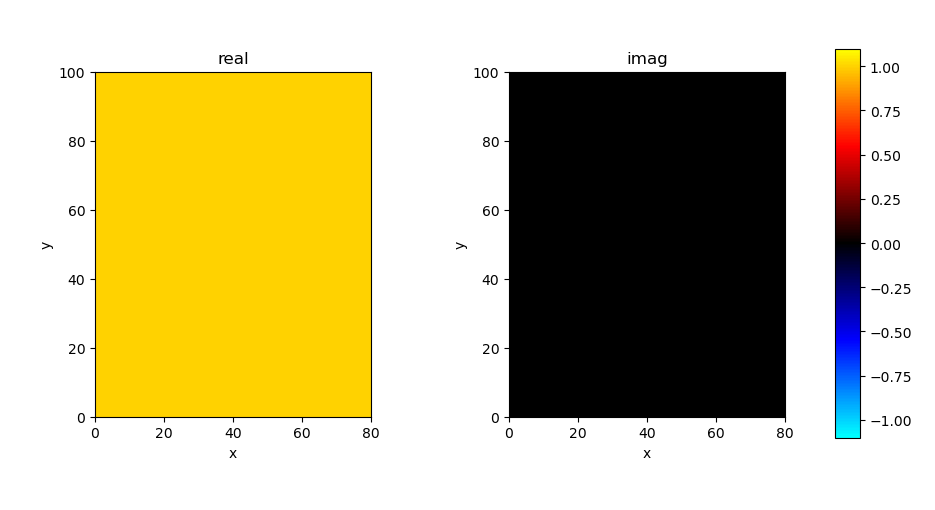

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


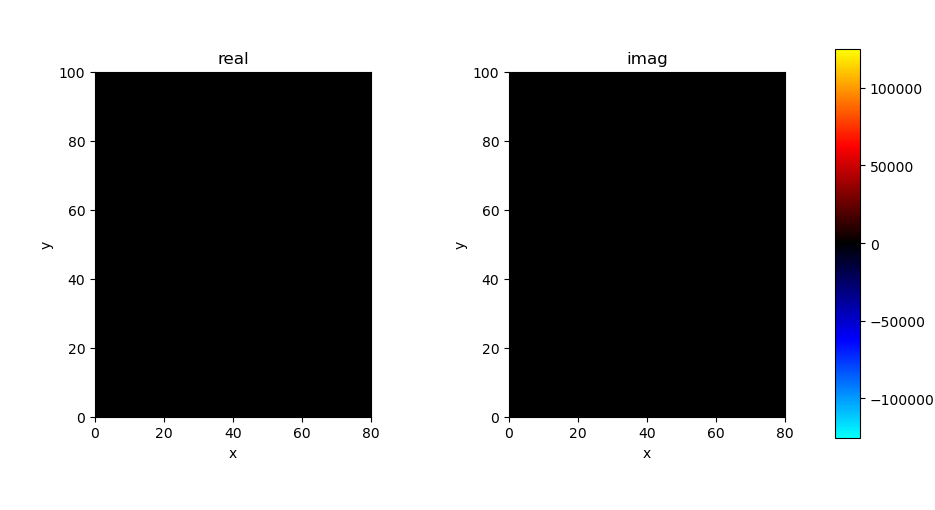

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [203]:
# construct Fourier basis functions

def fourier_basis(omega, n_freqs):
    def phi(x, deriv=0):
        k = np.fft.fftfreq(n_freqs)
        k = mre_pinn.fields.nd_coords([k, k]) * omega
        exp = np.exp(-2j * np.pi * x @ k.T)
        nax = np.newaxis
        if deriv == 2:
            return (-2j * np.pi)**2 * k[nax,:,nax,:] * (k[nax,...] * exp[...,nax])[...,nax]
        if deriv == 1:
            return -2j * np.pi * k[nax,...] * exp[...,nax]
        elif deriv == 0:
            return exp
    return phi

n_freqs = 80
phi = fourier_basis(omega=[80, 100], n_freqs=n_freqs)
phi_x = phi(x)
print_arrays(phi_x=phi_x)
             
Hphi_x = phi(x, deriv=2)
Lphi_x = Hphi_x[...,0,0] + Hphi_x[...,1,1]
print_arrays(Hphi_x=Hphi_x, Lphi_x=Lphi_x)

phi_x_xr = xr.DataArray(
    phi_x.reshape(wave.field.spatial_shape + (n_freqs, n_freqs)),
    dims=['x', 'y', 'k_x', 'k_y']
)
phi_x_xr.name = 'wave'

Lphi_x_xr = xr.DataArray(
    Lphi_x.reshape(wave.field.spatial_shape + (n_freqs, n_freqs)),
    dims=['x', 'y', 'k_x', 'k_y']
)
Lphi_x_xr.name = 'Laplacian'

mre_pinn.visual.XArrayViewer(phi_x_xr, col='part')
mre_pinn.visual.XArrayViewer(Lphi_x_xr, col='part')

In [204]:
# fit to wave field

print_arrays(phi_x=phi_x, u=u)

theta_u = np.linalg.lstsq(phi_x, u)[0]

u_pred = phi_x @ theta_u
Lu_pred = Lphi_x @ theta_u

print_arrays(theta_u=theta_u, u_pred=u_pred, Lu_pred=Lu_pred)

To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta_u = np.linalg.lstsq(phi_x, u)[0]



phi_x ∈ complex128 (8000, 6400)
u ∈ complex128 (8000, 2)
theta_u ∈ complex128 (6400, 2)
u_pred ∈ complex128 (8000, 2)
Lu_pred ∈ complex128 (8000, 2)


<IPython.core.display.Javascript object>


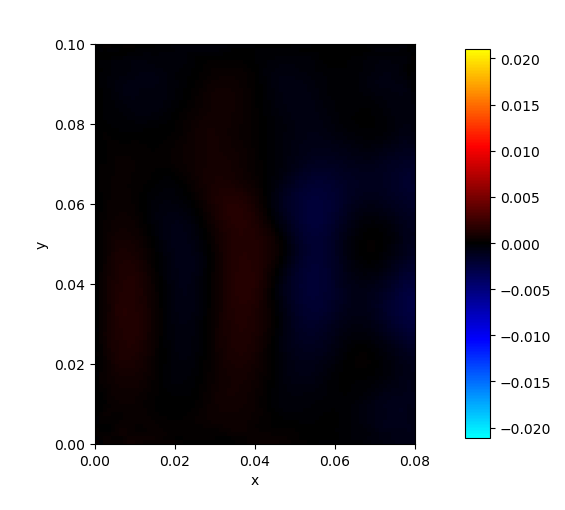

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


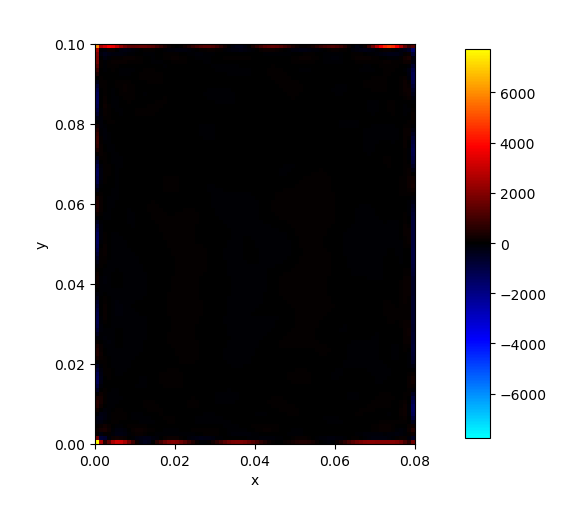

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [205]:
wave_pred = mre_pinn.utils.as_xarray(u_pred.reshape(wave.shape), like=wave)
laplace_pred = mre_pinn.utils.as_xarray(Lu_pred.reshape(wave.shape), like=wave)
mre_pinn.visual.XArrayViewer(wave_pred)
mre_pinn.visual.XArrayViewer(laplace_pred)

<IPython.core.display.Javascript object>


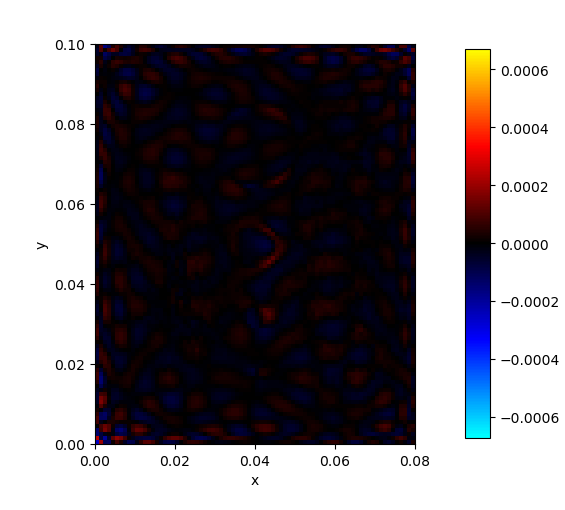

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [206]:
mre_pinn.visual.XArrayViewer(wave - wave_pred)

\begin{align}
    x &\in R^{N \times 2} \\
    \Phi: &R^2 \to C^K \\
    \Phi(x) &\in C^{N \times K} \\
    \theta_u &\in R^{K \times 2} \\
    \theta_\mu &\in R^{K \times 1} \\
    u &= \Phi(x) \theta_u \\
    \mu &= \Phi(x) \theta_\mu \\
    u &\in C^{N \times 2} \\
    \mu &\in C^{N \times 1} \\
    \mu \nabla^2 u &= -\rho \omega^2 u \\
    \Phi(x) \theta_\mu \nabla^2 \Phi(x) \theta_u &= -\rho \omega^2 \Phi(x) \theta_u \\
    \left(\nabla^2 \Phi(x) \theta_u  \Phi(x) \right) \theta_\mu &= -\rho \omega^2 \Phi(x) \theta_u \\
    \Psi(x) \theta_\mu &= f \\
    \Psi(x)^\top \Psi(x) \theta_\mu &= \Psi(x)^\top f
\end{align}

In [207]:
# fit elasticity field using Helmholtz equation

rho = 1000
omega = 60
f = -rho * (2 * np.pi * omega)**2 * u_pred

f = np.block([
    [f[:,0:1]],
    [f[:,1:2]]
])

psi_x = np.block([
    [Lu_pred[:,0:1] * phi_x],
    [Lu_pred[:,1:2] * phi_x]
])

print_arrays(f=f, psi_x=psi_x)

theta_mu = np.linalg.lstsq(psi_x, f)[0]
mu_pred = phi_x @ theta_mu

print_arrays(theta_mu=theta_mu, mu_pred=mu_pred)

To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta_mu = np.linalg.lstsq(psi_x, f)[0]



f ∈ complex128 (16000, 1)
psi_x ∈ complex128 (16000, 6400)
theta_mu ∈ complex128 (6400, 1)
mu_pred ∈ complex128 (8000, 1)


<IPython.core.display.Javascript object>


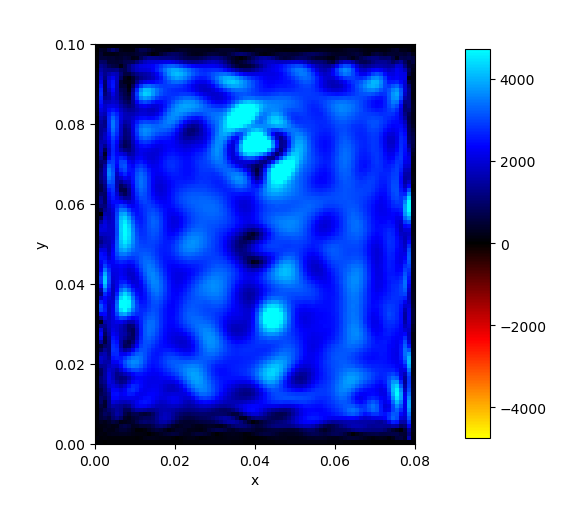

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [208]:
mre_pred = mre_pinn.utils.as_xarray(mu_pred.reshape(mre.shape), like=mre)
mre_pinn.visual.XArrayViewer(mre_pred, polar=True)

In [209]:
rho = 1000
omega = 60
f = -rho * (2 * np.pi * omega)**2 * u

f = np.block([
    [f[:,0:1]],
    [f[:,1:2]]
])

psi_x = np.block([
    [np.diag(Lu_pred[:,0])],
    [np.diag(Lu_pred[:,1])]
])

print_arrays(psi_x=psi_x, f=f)

mu_pred = np.linalg.lstsq(psi_x, f)[0]

print_arrays(mu_pred=mu_pred)

To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  mu_pred = np.linalg.lstsq(psi_x, f)[0]



psi_x ∈ complex128 (16000, 8000)
f ∈ complex128 (16000, 1)
mu_pred ∈ complex128 (8000, 1)


<IPython.core.display.Javascript object>


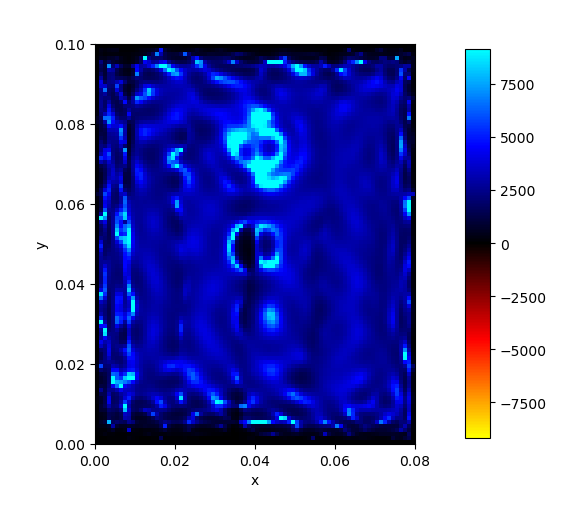

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [210]:
mre_pred = mre_pinn.utils.as_xarray(mu_pred.reshape(mre.shape), like=mre)
mre_pinn.visual.XArrayViewer(mre_pred, polar=True)